# Continuous-time LQ-optimal control (regulation) on a finite time interval with a free final state

We consider an LTI state-space model (but can also be time-varying), a quadratic cost function, fixed initial but final state, all this on an interval $[0,t_\mathrm{f}]$.

\begin{align*}
 \underset{\mathbf x(t),\mathbf u(t)}{\text{minimize}}&\quad\left[\mathbf x^\text{T}(t_\mathbf f)\underbrace{\mathbf S_\mathbf f}_{\geq 0}\mathbf x(t_\mathbf f)+\int_{0}^{t_\mathbf f}\left(\mathbf x^\text{T}(t)\underbrace{\mathbf Q}_{\geq 0}\mathbf x(t)+\mathbf u^\text{T}(t)\underbrace{\mathbf R}_{>0} u(t)\right)\text{d}t\right]\\
 \text{subject to}&\quad \dot{\mathbf x}(t)= \mathbf A\mathbf x(t)+ \mathbf B\mathbf u(t),\\
 &\quad \mathbf{x}(0) = \mathbf{r}_0,\\
  &\quad \mathbf x(t_\mathrm{f})\;\text{unspecified but forced to zero through the terminal cost}.
\end{align*}

## Two-point boundary value problem

The corresponding first-order necessary conditions come in the form of a two-point boundary value problem

\begin{equation*}
\begin{bmatrix}
 \dot {\mathbf x} \\ \dot{\boldsymbol\lambda}
\end{bmatrix}
= \underbrace{
\begin{bmatrix}
 \mathbf A & \mathbf B\mathbf R^{-1}\mathbf B^\text{T}\\
 \mathbf Q & - \mathbf A^\text{T}
\end{bmatrix}}_{\mathbf H}
\begin{bmatrix}
 \mathbf x \\ \boldsymbol\lambda
\end{bmatrix},
\end{equation*}

\begin{align*}
\mathbf x(t_\mathrm{0})&=\mathbf r_\mathrm{0},\\
\boldsymbol\lambda(t_\mathrm{f})&=-\mathbf S_\mathbf{f} \mathbf{x}(t_\mathrm{f}).
\end{align*}

Once we have a solution, an optimal control can be obtained via

\begin{equation*}
 \mathbf u(t) = \mathbf R^{-1}\mathbf B^\text{T}\boldsymbol \lambda(t).
\end{equation*}

First, define the state-space model by specifying the two matrices

In [1]:
n = 2                  # order of the system
m = 1                  # number of inputs (but beware the rest of the code is only tailored for m=1)
A = rand(n,n)
B = rand(n,m);

In [2]:
using LinearAlgebra

Q = diagm(0=>10*ones(n))    # weighting matrices for the quadratic cost function
R = diagm(0=>10*ones(m)) 
S₁ = diagm(0=>10*ones(n));

In [3]:
x₀ = [1.0, 2.0];             # initial states

In [4]:
t₀ = 0.0                 # initial time
t₁ = 10.0;               # final time

We build the Hamiltonian system (linear state and costate equations) represented by the matrix $\mathbf H$ 

In [5]:
H = [A B/R*B'; Q -A'] # the combined matrix for the Hamiltonian cannonical equations

4×4 Array{Float64,2}:
  0.257947   0.232929   0.0771776   0.0728461
  0.105704   0.648322   0.0728461   0.0687577
 10.0        0.0       -0.257947   -0.105704
  0.0       10.0       -0.232929   -0.648322

We solve for the costate at the beginning of the time interval by relyin on the linearity of the system, hence transition matrix can be defined and used

In [6]:
P = exp(H*t₁)        # "state"-transition matrix

P11 = P[1:n,1:n]
P12 = P[1:n,n+1:end]
P21 = P[n+1:end,1:n]
P22 = P[n+1:end,n+1:end]

λ₀ = -(S₁*P12+P22)\(S₁*P11+P21)*x₀  # solving for the initial value of costate

2-element Array{Float64,1}:
  304.187650014075
 -430.40095720290356

Now we solve for the states and costates during the whole time interval. Since the Hamilton canonical equations for a regular state space model, we can use [ControlSystems](https://github.com/JuliaControl/ControlSystems.jl) package. Alternatively, we could use the general [DifferentialEquations](https://docs.juliadiffeq.org/latest/) package.

In [7]:
using ControlSystems

G = ss(H,zeros(2n,1),Matrix{Float64}(I, 2n, 2n),0) # auxiliary system comprising the states and costates

w₀ = [x₀; λ₀]
t = 0:0.1:t₁
v(w,t) = [0]
y, t, w, uout = lsim(G,v,t,x0=w₀)
x = w[:,1:n]                                       # state
λ = w[:,n+1:end]                                   # costate
u = (R\B'*λ')';                                    # optimal control from the stationarity equation

┌ Info: Precompiling ControlSystems [a6e380b2-a6ca-5380-bf3e-84a91bcd477e]
└ @ Base loading.jl:1260


Finally we can plot the responses

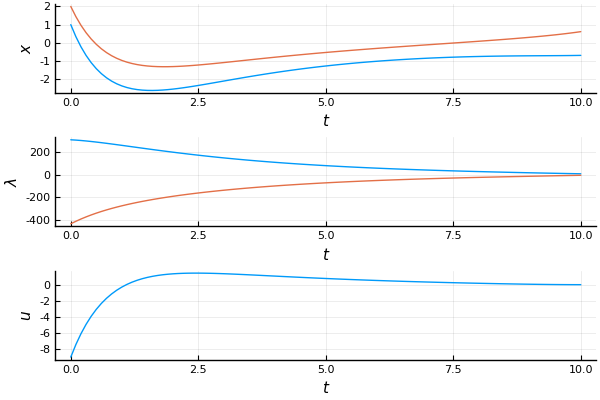

In [8]:
using Plots, LaTeXStrings
pyplot(xlabel=L"t",legend=false)

p1 = plot(t,x,ylabel=L"x")
p2 = plot(t,λ,ylabel=L"$\lambda$")
p3 = plot(t,u,ylabel=L"u")

plot(p1,p2,p3,layout=(3,1))

## Reformulation of the two-point BVP as an IVP using differential Riccati equation

Instead of solving the two-point boundary value Hamiltonian problem, we can reformulate it as an initial value problem. Actually, final value because the corresponding differential equation (Riccati equation) is initialized at the end of the time interval and solved backward

\begin{equation*}\boxed{
 - \dot{\mathbf S} =  \mathbf S \mathbf A + \mathbf A^\text{T} \mathbf S + \mathbf Q - \mathbf S\mathbf B\mathbf R^{-1}\mathbf B^\text{T} \mathbf S},\quad \mathbf{S}(t) = \mathbf{S}_\mathbf{f}. 
\end{equation*}

Once we have $\mathbf S(t)$ for the whole interval $[0,t_\mathbf{f}]$, the optimal control is

\begin{equation*}
 \mathbf u(t) = -\mathbf R^{-1}\mathbf B^\text{T}\mathbf S(t)\mathbf x(t),
\end{equation*}

which is a feedback control with the time-varying state feedback gain

\begin{equation*}
 \mathbf K(t) = \mathbf R^{-1}\mathbf B^\text{T}\mathbf S(t),
\end{equation*}

assuming a negative feedback.

Note also that $\mathbf S(t)\geq0$, that is, a solution of (matrix) differential Riccati equation is guaranteed to be positive semidefinite.

Let's enter the matrices defining the models in Julia

In [9]:
using DifferentialEquations

┌ Info: Precompiling DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1260


The right hand side of the Riccati differential equation (assuming $\dot{\mathbf{S}}$ on the left hand side) is

In [10]:
f(S,p,t) = -S*A - A'*S - Q + S*B/R*B'*S

f (generic function with 1 method)

The problem defined in the format of the `DifferentialEquations` package is below. Note that the solver has no problem accepting the reverse time direction.

Compared to the two-point boundar-value problem formulation above, here we can safely afford to examine both short and long time intervals

In [11]:
t₁ = 100

100

In [12]:
prob = ODEProblem(f,S₁,(t₁,t₀))

ODEProblem with uType Array{Float64,2} and tType Float64. In-place: false
timespan: (100.0, 0.0)
u0: [10.0 0.0; 0.0 10.0]

Now solve the problem

In [13]:
sol = solve(prob,reltol=1e-8,abstol=1e-8);

And for convenience reverse the ordering of the time and the solutions of the Riccati equations.

In [14]:
t = reverse(sol.t);
S = reverse(sol.u);

For plotting we need to reformat `S` from an array of matrices into a matrix of arrays - as usual... 

In [15]:
SS = [[z[i,j] for z in S] for i=1:n, j=1:m]

2×1 Array{Array{Float64,1},2}:
 [227.99998390179803, 227.99998390179883, 227.99998390178263, 227.9999839016982, 227.99998390117892, 227.99998389756283, 227.99998386736496, 227.99998392512887, 227.99998384940415, 227.99998386415288  …  14.44413437736059, 13.63245347929447, 12.933938289087866, 12.324048114326388, 11.78564738315924, 11.309669718211758, 10.88799929784862, 10.521967359790755, 10.204441818725888, 10.0]
 [-273.42311374613894, -273.42311374613894, -273.42311374611296, -273.42311374596835, -273.423113745083, -273.4231137390212, -273.42311368814046, -273.42311379013995, -273.42311366644924, -273.42311371122264  …  -4.265788311723567, -3.2822129872531356, -2.481374651420743, -1.8310949455153924, -1.3061892627427405, -0.8882256327422196, -0.5586478599901226, -0.3057300229966137, -0.11203601938739874, 0.0]

Let's plot just one element of the matrix function `S`

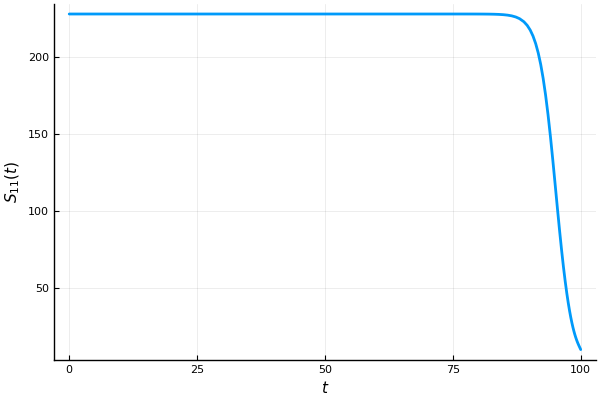

In [16]:
using Plots, LaTeXStrings
pyplot()

plot(t,SS[1,1],linewidth=2,xlabel=L"t",ylabel=L"S_{11}(t)",label="")

Computing the time-varying state feedback gain is then straightforward. 

In [29]:
K = [R\B'*s for s in S];               # will consider a negative feedback

Again, for the purpose of plotting we must reformat

In [30]:
KK = [[z[i,j] for z in K] for i=1:m, j=1:n] 

1×2 Array{Array{Float64,1},2}:
 [-2.64235, -2.64235, -2.64235, -2.64235, -2.64235, -2.64235, -2.64235, -2.64235, -2.64235, -2.64235  …  0.915208, 0.92546, 0.9305, 0.930842, 0.927069, 0.919911, 0.910196, 0.899012, 0.887178, 0.878508]  …  [5.92336, 5.92336, 5.92336, 5.92336, 5.92336, 5.92336, 5.92336, 5.92336, 5.92336, 5.92336  …  1.28172, 1.22185, 1.16284, 1.10488, 1.04844, 0.994453, 0.943645, 0.89754, 0.856279, 0.829203]

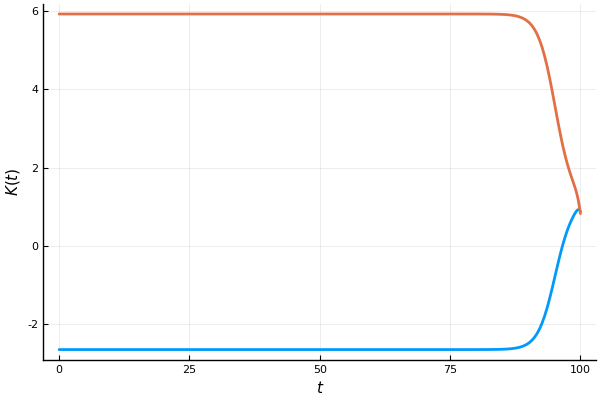

In [31]:
plot(t,KK[:],linewidth=2,xlabel=L"t",ylabel=L"K(t)",label="")    # array of array issue, that's why the index

Now simulate the closed-loop response to some nonzero initial state 

In [32]:
x₀ = [1.0, 2.0];

By solving the Riccati differential equation, we have an array of values of `K` but we need to have a function. Interpolation is the way to go.

In [33]:
using Interpolations

In [34]:
Kintp = LinearInterpolation(t,K);

Now build the right hand side for the state equation. The state-feedback gain will be here a time-varying parameter. Check out the [explanation of using parameterized function with DifferentialEquations documentation](https://docs.juliadiffeq.org/stable/tutorials/ode_example/#Example-3:-Solving-Nonhomogeneous-Equations-using-Parameterized-Functions-1).

In [35]:
fclosed(x,K,t) = (A - B*K(t))*x

prob = ODEProblem(fclosed,x₀,[t₀,t₁],t->Kintp(t))

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: false
timespan: (0.0, 100.0)
u0: [1.0, 2.0]

What now remains is to solve the problem

In [36]:
sol = solve(prob);

And plot the solution

In [37]:
xsol = sol.u;

In [38]:
xsol = [[z[i] for z in xsol] for i=1:n];

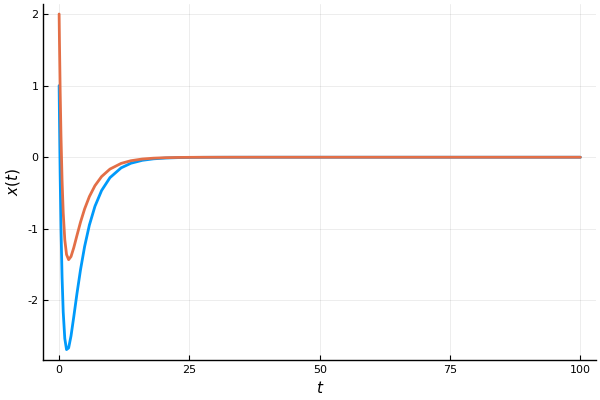

In [39]:
plot(sol.t,xsol[:],linewidth=2,xlabel=L"t",ylabel=L"x(t)",label=[L"x_1" L"x_2"])

## References

[1] Lewis, Frank, Draguna Vrabie, and Vassilis L. Syrmos. Optimal Control. 3rd edition. Hoboken: Wiley, 2012.

[2] Kirk, Donald E. Optimal Control Theory: An Introduction. Dover Publications, 2004.